In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
import yfinance as yf

data = yf.download(tickers = "GLD", start="2017-12-01", end="2023-06-16", interval='1d')
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,120.940002,122.430000,120.739998,121.589996,121.589996,13080100
2017-12-04,121.150002,121.199997,120.839996,121.180000,121.180000,6943700
2017-12-05,120.099998,120.510002,119.720001,120.320000,120.320000,10041200
2017-12-06,120.040001,120.440002,119.870003,120.070000,120.070000,6643000
2017-12-07,119.010002,119.239998,118.099998,118.489998,118.489998,12900200
...,...,...,...,...,...,...
2023-06-09,182.360001,182.789993,181.720001,182.039993,182.039993,4379200
2023-06-12,181.800003,181.940002,181.039993,181.880005,181.880005,4873600
2023-06-13,182.100006,182.429993,180.169998,180.539993,180.539993,5126700


In [3]:
data = data.reset_index('Date', inplace=False)

In [4]:
# 2. Đọc file dữ liệu giá vàng GC=F và chia train test validate theo tỉ lệ 7:2:1
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [5]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [6]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
#y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
#y_pred_val =  model.predict(n_periods=len(y_val))

In [7]:
# Chọn kernel tốt nhất
kernels = [RBF(), Matern(), RationalQuadratic(), ExpSineSquared(), DotProduct()]
param_grid = {'kernel': kernels}

gpr = GaussianProcessRegressor()
grid_search = GridSearchCV(gpr, param_grid, cv=KFold(n_splits=5))

grid_search.fit(x_train, y_train)


print("Best Kernel:", grid_search.best_estimator_.kernel)
print("Best Score:", grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/us

Best Kernel: RationalQuadratic(alpha=1, length_scale=1)
Best Score: -4.234046778637477


In [8]:
# Tạo mô hình GPR
kernel = RationalQuadratic(alpha=1, length_scale=1)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)


In [9]:
gpr.fit(x_train, y_train)

GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=1),
                         random_state=42)

In [10]:
y_pred = gpr.predict(x_test)

In [11]:
y_pred_val =  gpr.predict(x_val)

In [12]:
last_index =  data.index[-1]
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = gpr.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[137.34355901 137.31948188 137.29545532 137.27147911 137.24755307
 137.22367699 137.19985068 137.17607393 137.15234655 137.12866835
 137.10503914 137.08145871 137.05792689 137.03444348 137.01100829
 136.98762113 136.96428183 136.94099018 136.91774601 136.89454914
 136.87139938 136.84829655 136.82524047 136.80223096 136.77926784
 136.75635094 136.73348008 136.71065508 136.68787578 136.66514199]


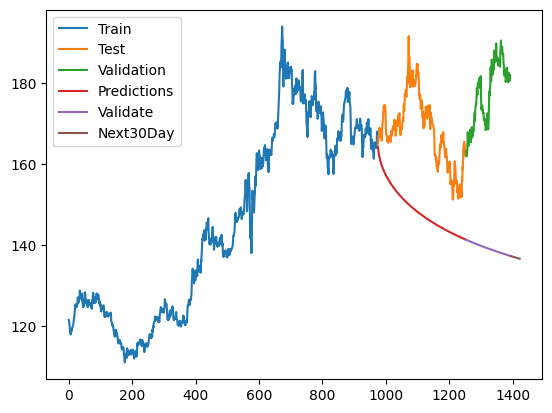

In [13]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(range(last_index+1, last_index+31),y_next_30_days)
plt.legend(['Train', 'Test', 'Validation', 'Predictions','Validate','Next30Day'])
plt.show()